In [38]:
import warnings
warnings.filterwarnings('ignore')

from Data_Preprocessing import exp_var, hate_crime_combined

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE

from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.nn.functional as F

In [3]:
exp_var

['hate_crime',
 'hate_crime_combined',
 'hc_by_year',
 'region_grouped',
 'race_grouped',
 'indexed_df']

### Supervised Learning with Timeseries

https://www.bi4all.pt/en/news/en-blog/supervised-machine-learning-in-time-series-forecasting/

https://machinelearningmastery.com/how-to-develop-an-autoregression-forecast-model-for-household-electricity-consumption/

https://pbpython.com/categorical-encoding.html

In [4]:
#create lag features t, t-1, t-2, etc
#can compute more advanced features like rolling mean with pd.rolling() 
#or expanding windows pd.expanding()
#use ridge regression to select most impactful lag features

#walk forward validation with sklearn TimeSeriesSplit()

#evaluation with MAE, MSE, RMSE

In [5]:
print(hate_crime_combined.shape)
hate_crime_combined.head()

(219577, 21)


,DATA_YEAR,STATE_ABBR,REGION_NAME,POPULATION_GROUP_CODE,INCIDENT_DATE,TOTAL_OFFENDER_COUNT,OFFENDER_RACE,VICTIM_COUNT,OFFENSE_NAME,LOCATION_NAME,...,VICTIM_TYPES,Congress,Year Start,Year End,House Majority,Senate Majority,Presidency,President,Party Government,INCIDENT_COUNT
0,1991,AR,South,5,1991-08-31,1,White,1,Intimidation,Highway/Road/Alley/Street/Sidewalk,...,Individual,102,1991,1993,Democrats,Democrats,Republican,G.H.W Bush,Divided,1
1,1991,AR,South,6,1991-09-19,1,Black or African American,1,Simple Assault,Highway/Road/Alley/Street/Sidewalk,...,Individual,102,1991,1993,Democrats,Democrats,Republican,G.H.W Bush,Divided,1
2,1991,AR,South,3,1991-07-04,1,Black or African American,1,Aggravated Assault,Residence/Home,...,Individual,102,1991,1993,Democrats,Democrats,Republican,G.H.W Bush,Divided,1
3,1991,AR,South,3,1991-12-24,1,Black or African American,2,Aggravated Assault;Destruction/Damage/Vandalis...,Highway/Road/Alley/Street/Sidewalk,...,Individual,102,1991,1993,Democrats,Democrats,Republican,G.H.W Bush,Divided,1
4,1991,AR,South,3,1991-12-23,1,Black or African American,1,Aggravated Assault,Service/Gas Station,...,Individual,102,1991,1993,Democrats,Democrats,Republican,G.H.W Bush,Divided,1


In [6]:
#group by bias type -- ADD THIS TO VSCODE LATER
hate_crime_combined['TOTAL_INCIDENTS'] = 1
hate_crime_combined.columns

bias_grouped = hate_crime_combined.groupby(['DATA_YEAR','BIAS_DESC'])['TOTAL_INCIDENTS'].sum().reset_index()
bias_grouped.set_index('DATA_YEAR', inplace=True)
bias_grouped

,BIAS_DESC,TOTAL_INCIDENTS
DATA_YEAR,,
1991,Anti-Arab,73
1991,Anti-Asian,269
1991,Anti-Atheism/Agnosticism,4
1991,Anti-Bisexual,1
1991,Anti-Black or African American,1629
...,...,...
2020,Anti-Physical Disability,72
2020,Anti-Protestant,40
2020,Anti-Sikh,172


In [7]:
muslim_bias = bias_grouped[bias_grouped['BIAS_DESC'] == "Anti-Islamic (Muslim)"]
black_bias = bias_grouped[bias_grouped['BIAS_DESC'] == "Anti-Black or African American"]
asian_bias = bias_grouped[bias_grouped['BIAS_DESC'] == "Anti-Asian"]
queer_bias = bias_grouped[bias_grouped['BIAS_DESC'] == "Anti-Gay (Male)"] + bias_grouped[bias_grouped['BIAS_DESC'] == "Anti-Lesbian (Female)"]


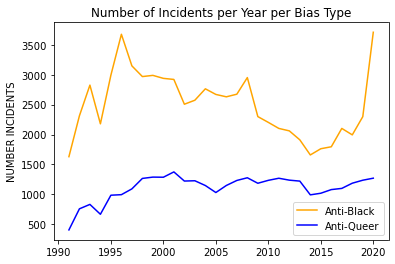

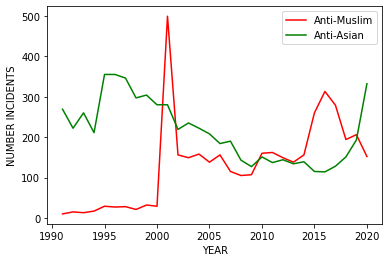

In [8]:
plt.plot(black_bias['TOTAL_INCIDENTS'], color='orange', label='Anti-Black')
plt.plot(queer_bias['TOTAL_INCIDENTS'], color='blue', label='Anti-Queer')
plt.ylabel('NUMBER INCIDENTS')
plt.title('Number of Incidents per Year per Bias Type')
plt.legend()
plt.show()

plt.plot(muslim_bias['TOTAL_INCIDENTS'], color='red', label='Anti-Muslim')
plt.plot(asian_bias['TOTAL_INCIDENTS'], color='green', label='Anti-Asian')
plt.xlabel('YEAR')
plt.ylabel('NUMBER INCIDENTS')
plt.legend()
plt.show()

## Proprocessing for Supervised Learning with Timeseries

In [9]:
hate_crime_combined['TOTAL_INCIDENTS'] = 1
hate_crime_combined.columns

Index(['DATA_YEAR', 'STATE_ABBR', 'REGION_NAME', 'POPULATION_GROUP_CODE',
       'INCIDENT_DATE', 'TOTAL_OFFENDER_COUNT', 'OFFENDER_RACE',
       'VICTIM_COUNT', 'OFFENSE_NAME', 'LOCATION_NAME', 'BIAS_DESC',
       'VICTIM_TYPES', 'Congress', 'Year Start', 'Year End', 'House Majority',
       'Senate Majority', 'Presidency', 'President', 'Party Government',
       'INCIDENT_COUNT', 'TOTAL_INCIDENTS'],
      dtype='object')

In [10]:
#isolate columns of interest
sml_df = hate_crime_combined[['INCIDENT_DATE', 'REGION_NAME', 'BIAS_DESC', 'Presidency','TOTAL_INCIDENTS']]

#convert incident date to datetime, isolate month as frequency
sml_df['INCIDENT_MONTH'] = pd.to_datetime(sml_df['INCIDENT_DATE']).dt.to_period('M')

#convert Incident Month to datetime
#sml_df['INCIDENT_MONTH'] = sml_df['INCIDENT_MONTH'].apply(lambda x: x.to_timestamp(freq='M'))

In [11]:
#drop Incident Date column after engineering Month column
sml_df.drop('INCIDENT_DATE', axis=1, inplace=True)
sml_df

,REGION_NAME,BIAS_DESC,Presidency,TOTAL_INCIDENTS,INCIDENT_MONTH
0,South,Anti-Black or African American,Republican,1,1991-08
1,South,Anti-White,Republican,1,1991-09
2,South,Anti-Black or African American,Republican,1,1991-07
3,South,Anti-White,Republican,1,1991-12
4,South,Anti-White,Republican,1,1991-12
...,...,...,...,...,...
111023,West,Anti-Lesbian (Female),Republican,1,2020-11
111024,West,Anti-White,Republican,1,2020-07
111025,West,Anti-White,Republican,1,2020-10
111026,West,Anti-Female,Republican,1,2020-01


In [12]:
#categorical encoding

encode_list = ['BIAS_DESC', 'REGION_NAME', 'INCIDENT_MONTH', 'Presidency']

for col in encode_list:
    sml_df[col] = sml_df[col].astype('category')
    sml_df[str(col)+'_ENC'] = sml_df[col].cat.codes
    sml_df.drop(col, axis=1, inplace=True)

#### Timeseries with Monthly number of Incidents per Region per Bias with Political Climate

In [13]:
region_bias_presidency_ts = sml_df.groupby(['INCIDENT_MONTH_ENC', 
                                            'REGION_NAME_ENC', 
                                            'BIAS_DESC_ENC', 
                                            'Presidency_ENC'])['TOTAL_INCIDENTS'].sum().reset_index()
region_bias_presidency_ts

,INCIDENT_MONTH_ENC,REGION_NAME_ENC,BIAS_DESC_ENC,Presidency_ENC,TOTAL_INCIDENTS
0,0,0,0,1,7
1,0,0,1,1,1
2,0,0,4,1,10
3,0,0,16,1,3
4,0,0,23,1,1
...,...,...,...,...,...
22156,359,5,28,1,1
22157,359,5,29,1,1
22158,359,5,30,1,1
22159,359,5,31,1,5


#### Timeseries with Monthly number of Incidents per Region per Bias

In [14]:
region_bias_ts = sml_df.groupby(['INCIDENT_MONTH_ENC', 
                                 'REGION_NAME_ENC', 
                                 'BIAS_DESC_ENC'])['TOTAL_INCIDENTS'].sum().reset_index()
region_bias_ts

,INCIDENT_MONTH_ENC,REGION_NAME_ENC,BIAS_DESC_ENC,TOTAL_INCIDENTS
0,0,0,0,7
1,0,0,1,1
2,0,0,4,10
3,0,0,16,3
4,0,0,23,1
...,...,...,...,...
22156,359,5,28,1
22157,359,5,29,1
22158,359,5,30,1
22159,359,5,31,5


#### Timeseries with Monthly number of Incidents per Region

In [15]:
#groupby and set index to date
region_ts = sml_df.groupby(['INCIDENT_MONTH_ENC', 
                            'REGION_NAME_ENC'])['TOTAL_INCIDENTS'].sum().reset_index()
#region_ts = region_ts.set_index('INCIDENT_MONTH')
region_ts

,INCIDENT_MONTH_ENC,REGION_NAME_ENC,TOTAL_INCIDENTS
0,0,0,37
1,0,1,171
2,0,3,65
3,0,5,29
4,1,0,51
...,...,...,...
1478,359,0,139
1479,359,1,144
1480,359,2,7
1481,359,3,176


#### Timeseries with Monthly number of Incidents per Bias

In [16]:
#groupby and set index to date
bias_ts = sml_df.groupby(['INCIDENT_MONTH_ENC', 
                          'BIAS_DESC_ENC'])['TOTAL_INCIDENTS'].sum().reset_index()
#bias_ts = bias_ts.set_index('INCIDENT_MONTH')
bias_ts

,INCIDENT_MONTH_ENC,BIAS_DESC_ENC,TOTAL_INCIDENTS
0,0,0,25
1,0,1,9
2,0,2,1
3,0,4,90
4,0,9,7
...,...,...,...
7359,359,28,7
7360,359,29,6
7361,359,30,14
7362,359,31,10


#### Timeseries with Monthly number of Incidents per Political Climate

In [17]:
#groupby and set index to date
presidency_ts = sml_df.groupby(['INCIDENT_MONTH_ENC', 
                                'Presidency_ENC'])['TOTAL_INCIDENTS'].sum().reset_index()
#bias_ts = bias_ts.set_index('INCIDENT_MONTH')
presidency_ts

,INCIDENT_MONTH_ENC,Presidency_ENC,TOTAL_INCIDENTS
0,0,1,302
1,1,1,287
2,2,1,287
3,3,1,309
4,4,1,371
...,...,...,...
355,355,1,1085
356,356,1,952
357,357,1,1004
358,358,1,780


#### Timeseries with Monthly number of Incidents per Region per Political Climate

In [18]:
#groupby and set index to date
region_presidency_ts = sml_df.groupby(['INCIDENT_MONTH_ENC', 
                                       'REGION_NAME_ENC', 
                                       'Presidency_ENC'])['TOTAL_INCIDENTS'].sum().reset_index()
#bias_ts = bias_ts.set_index('INCIDENT_MONTH')
region_presidency_ts

,INCIDENT_MONTH_ENC,REGION_NAME_ENC,Presidency_ENC,TOTAL_INCIDENTS
0,0,0,1,37
1,0,1,1,171
2,0,3,1,65
3,0,5,1,29
4,1,0,1,51
...,...,...,...,...
1478,359,0,1,139
1479,359,1,1,144
1480,359,2,1,7
1481,359,3,1,176


### Engineering Lag Features
create lag features with shift() and diff()

In [19]:
df_list = [region_bias_presidency_ts, region_presidency_ts, 
           region_bias_ts, region_ts, bias_ts, presidency_ts]

for df in df_list:
    df['MONTH-1'] = df['TOTAL_INCIDENTS'].shift()
    df['MONTH-2'] = df['MONTH-1'].shift()
    
    df['MONTH-1_DIFF'] = df['MONTH-1'].diff()
    df['MONTH-2_DIFF'] = df['MONTH-2'].diff()
    
    df.dropna(inplace=True)
    df.reset_index(inplace=True, drop=True)
    display(df.head(5))

,INCIDENT_MONTH_ENC,REGION_NAME_ENC,BIAS_DESC_ENC,Presidency_ENC,TOTAL_INCIDENTS,MONTH-1,MONTH-2,MONTH-1_DIFF,MONTH-2_DIFF
0,0,0,16,1,3,10.0,1.0,9.0,-6.0
1,0,0,23,1,1,3.0,10.0,-7.0,9.0
2,0,0,26,1,3,1.0,3.0,-2.0,-7.0
3,0,0,27,1,1,3.0,1.0,2.0,-2.0
4,0,0,32,1,11,1.0,3.0,-2.0,2.0


,INCIDENT_MONTH_ENC,REGION_NAME_ENC,Presidency_ENC,TOTAL_INCIDENTS,MONTH-1,MONTH-2,MONTH-1_DIFF,MONTH-2_DIFF
0,0,5,1,29,65.0,171.0,-106.0,134.0
1,1,0,1,51,29.0,65.0,-36.0,-106.0
2,1,1,1,148,51.0,29.0,22.0,-36.0
3,1,3,1,51,148.0,51.0,97.0,22.0
4,1,5,1,37,51.0,148.0,-97.0,97.0


,INCIDENT_MONTH_ENC,REGION_NAME_ENC,BIAS_DESC_ENC,TOTAL_INCIDENTS,MONTH-1,MONTH-2,MONTH-1_DIFF,MONTH-2_DIFF
0,0,0,16,3,10.0,1.0,9.0,-6.0
1,0,0,23,1,3.0,10.0,-7.0,9.0
2,0,0,26,3,1.0,3.0,-2.0,-7.0
3,0,0,27,1,3.0,1.0,2.0,-2.0
4,0,0,32,11,1.0,3.0,-2.0,2.0


,INCIDENT_MONTH_ENC,REGION_NAME_ENC,TOTAL_INCIDENTS,MONTH-1,MONTH-2,MONTH-1_DIFF,MONTH-2_DIFF
0,0,5,29,65.0,171.0,-106.0,134.0
1,1,0,51,29.0,65.0,-36.0,-106.0
2,1,1,148,51.0,29.0,22.0,-36.0
3,1,3,51,148.0,51.0,97.0,22.0
4,1,5,37,51.0,148.0,-97.0,97.0


,INCIDENT_MONTH_ENC,BIAS_DESC_ENC,TOTAL_INCIDENTS,MONTH-1,MONTH-2,MONTH-1_DIFF,MONTH-2_DIFF
0,0,4,90,1.0,9.0,-8.0,-16.0
1,0,9,7,90.0,1.0,89.0,-8.0
2,0,13,10,7.0,90.0,-83.0,89.0
3,0,14,1,10.0,7.0,3.0,-83.0
4,0,16,86,1.0,10.0,-9.0,3.0


,INCIDENT_MONTH_ENC,Presidency_ENC,TOTAL_INCIDENTS,MONTH-1,MONTH-2,MONTH-1_DIFF,MONTH-2_DIFF
0,3,1,309,287.0,287.0,0.0,-15.0
1,4,1,371,309.0,287.0,22.0,0.0
2,5,1,363,371.0,309.0,62.0,22.0
3,6,1,461,363.0,371.0,-8.0,62.0
4,7,1,511,461.0,363.0,98.0,-8.0


## Modeling

In [20]:
def validation_split(dataset, y_column, validation_percentage):
    '''
    Input:
    dataset = dataframe processed for machine learning
    validation_percentage = percent of dataset to withold for validation, expressed as decimal
    
    Return:
    X_train, X_test, y_train, y_test
    '''
    #train test split
    #train test split with 85/15
    length = len(dataset)
    val_size = round(length * validation_percentage)
    cut_off = length-val_size

    X = dataset.drop([y_column], axis=1)
    y = dataset[y_column]

    X_train, X_test = X[:cut_off], X[cut_off:]
    y_train, y_test = y[:cut_off], y[cut_off:]
    
    return (X_train, X_test, y_train, y_test)

#### Random Forest Regressor

In [21]:
def random_forest_func(dataset, num_estimators, dataset_string):
    '''
    Input:
    dataset = a preprocessed pandas df for machine learning
    dataset_string = the title of the dataset
    num_estimators = number of estimators for the Random Forest Regression model
    
    Function:
    Callss validation_split function, reserving the last 15% of the dataset for validation, 
    Fits the dataset to a RandomForestRegressor and predicts results,
    Calculates MAE and RMSE for predictions compared to validation set.
    
    Return:
    Dataframe of dataset_string, calculated MAE, calculated RMSE
    '''
    #instantiate lists to convert to results dataframe
    MAE_list = []
    RMSE_list = []
    label_list = []
    
    #call validation_split function
    X_train, X_test, y_train, y_test = validation_split(dataset, 'TOTAL_INCIDENTS', 0.15)
    y_train, y_test = np.array(y_train), np.array(y_test)

    #instantiate, fit, and predict RandomForestRegressor model
    RF_model = RandomForestRegressor(n_estimators=num_estimators, n_jobs=-1, random_state=42).fit(X_train, y_train)
    y_pred = RF_model.predict(X_test)
    
    #calculate performance metrics
    MAE_result = MAE(y_test, y_pred)
    MAE_list.append(MAE_result)
    
    MSE_result = MSE(y_test, y_pred)
    RMSE_result = np.sqrt(MSE_result)
    RMSE_list.append(RMSE_result)
    
    label_list.append(dataset_string)
    
    return pd.DataFrame({'Title':label_list, 
                         'MAE':MAE_list, 
                         'RMSE':RMSE_list})

In [22]:
region_results = random_forest_func(region_ts, 1000, 
                                    'Incidents by Region')
region_results

,Title,MAE,RMSE
0,Incidents by Region,52.197874,70.015608


In [23]:
bias_results = random_forest_func(bias_ts, 1000, 
                                  'Incidents by Bias Type')
bias_results

,Title,MAE,RMSE
0,Incidents by Bias Type,8.16402,24.381925


In [24]:
region_bias_results = random_forest_func(region_bias_ts, 1000, 
                                         'Incidents by Region and Bias Type')
region_bias_results

,Title,MAE,RMSE
0,Incidents by Region and Bias Type,3.893536,9.368843


In [25]:
region_bias_presidency_results = random_forest_func(region_bias_presidency_ts, 1000, 
                                                    'Incidents by Region, Bias Type, and Presidency')
region_bias_presidency_results

,Title,MAE,RMSE
0,"Incidents by Region, Bias Type, and Presidency",3.892302,9.37097


In [26]:
region_presidency_results = random_forest_func(region_presidency_ts, 1000, 
                                               'Incidents by Region and Presidency')
region_presidency_results

,Title,MAE,RMSE
0,Incidents by Region and Presidency,52.831,71.689317


In [27]:
presidency_results = random_forest_func(presidency_ts, 1000, 
                                        'Incidents by Presidency')
presidency_results

,Title,MAE,RMSE
0,Incidents by Presidency,115.396333,178.251851


In [28]:
combined_results_list = [region_results, bias_results, region_bias_results, 
                         region_bias_presidency_results, region_presidency_results, 
                         presidency_results] 
combined_results = pd.concat(combined_results_list)
combined_results = combined_results.sort_values('MAE', ascending=True)
combined_results

,Title,MAE,RMSE
0,"Incidents by Region, Bias Type, and Presidency",3.892302,9.370970
0,Incidents by Region and Bias Type,3.893536,9.368843
0,Incidents by Bias Type,8.164020,24.381925
0,Incidents by Region,52.197874,70.015608
0,Incidents by Region and Presidency,52.831000,71.689317
0,Incidents by Presidency,115.396333,178.251851


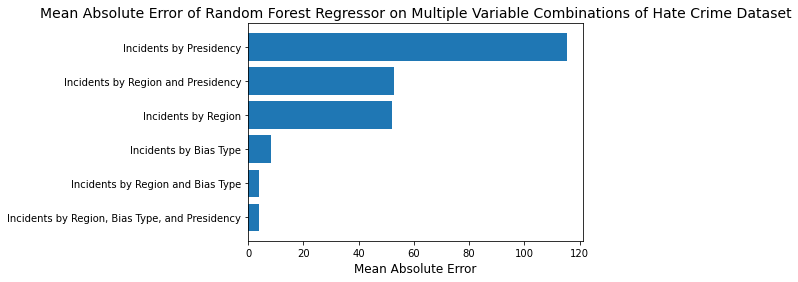

In [29]:
plt.barh(combined_results['Title'],combined_results['MAE'])
plt.xlabel('Mean Absolute Error', fontsize=12)
plt.title('Mean Absolute Error of Random Forest Regressor on Multiple Variable Combinations of Hate Crime Dataset',
         fontsize=14)

plt.show()

###### Random Forest Parameter Tuning

In [45]:
X_train, X_test, y_train, y_test = validation_split(dataset=region_bias_ts, y_column='TOTAL_INCIDENTS', validation_percentage=0.15)

In [47]:
params_dt = {'max_depth':[20, 50, 80], 
             'min_samples_leaf':[0.0004,0.004], 
             'max_features':[0.3, 0.5, 1]}

grid_dt = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), 
                       param_grid=params_dt, 
                       scoring='neg_mean_squared_error')
grid_dt.fit(X_train, y_train)

#print best parameters
print('Best parameters from GridSearch CV: {:}'.format(grid_dt.best_params_))
print(' ')

#predict on test set with best estimator
y_pred_dt_tuned = grid_dt.best_estimator_.predict(X_test)

#RMSE of best estimator
MAE_dt_tuned = MAE(y_test, y_pred_dt_tuned)

print('Test MAE of tuned dt model: {:.2f}'.format(MAE_dt_tuned))

Best parameters from GridSearch CV: {'max_depth': 50, 'max_features': 0.5, 'min_samples_leaf': 0.0004}
 
Test MAE of tuned dt model: 4.37


#### KNN Regressor

In [29]:
dataset=region_bias_ts

In [30]:
#train test split
#train test split with 85/15
length = len(dataset)
val_size = round(length * .15)
cut_off = length-val_size

train = dataset.iloc[:cut_off] 
test = dataset.iloc[cut_off:]

X_train, X_test = train.drop(['TOTAL_INCIDENTS'], axis=1), test.drop(['TOTAL_INCIDENTS'], axis=1)
y_train, y_test = np.array(train['TOTAL_INCIDENTS']), np.array(test['TOTAL_INCIDENTS'])

In [31]:
#scale X
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.fit_transform(X_test)

In [32]:
#Grid Search to find optimal k value
params = {'n_neighbors': np.arange(3,20,2)}

k_neighbors = KNeighborsRegressor()

cv = GridSearchCV(k_neighbors, params, cv=20)
cv.fit(X_train_sc, y_train)
cv.best_params_

best_k = list(cv.best_params_.values())[0]
print('Best k value: {:.0f}'.format(best_k))

Best k value: 7


In [33]:
#instantiate and fit KNR model
knr = KNeighborsRegressor(n_neighbors=best_k).fit(X_train_sc, y_train)
knr_pred = knr.predict(X_test_sc)

In [34]:
#calculate validation MAE
knr_MAE = MAE(y_test, knr_pred)
print('KNR model training MAE: {:.3f}'.format(knr_MAE))

#calculate validation RMSE
knr_RMSE = np.sqrt(MSE(y_test, knr_pred))
print('KNR model validation RMSE: {:.3f}'.format(knr_RMSE))

KNR model training MAE: 7.524
KNR model validation RMSE: 14.271


### Neural Network

In [48]:
def neural_network_processing(dataset, y_column):
    '''
    Input:
    dataset = dataframe processed for machine learning
    y_column = column to predict as a string

    Function:
    Call validation_split function and splits into 85% training and 15% validation sets
    Converts train and validation sets into tensors and reshapes

    Return:
    X_train, y_train as reshaped tensors for PyTorch Neural Network Model
    '''
    #call validation_split function
    X_train, X_test, y_train, y_test = validation_split(dataset, y_column, 0.15)
    
    #convert arrays to tensors for PyTorch
    X_train_tensor = torch.FloatTensor(X_train.values)
    X_test_tensor = torch.FloatTensor(X_test.values)

    y_train_tensor = torch.FloatTensor(y_train.values)
    y_test_tensor = torch.FloatTensor(y_test.values)

    #reshape target tensors 
    new_shape_train = (len(y_train_tensor), 1)
    y_train_tensor_reshape = y_train_tensor.view(new_shape_train)

    new_shape_test = (len(y_test_tensor), 1)
    y_test_tensor_reshape = y_test_tensor.view(new_shape_test)
    
    return X_train_tensor, y_train_tensor_reshape

In [49]:
neural_network_processing(region_ts, 'TOTAL_INCIDENTS')

(tensor([[   0.,    5.,   65.,  171., -106.,  134.],
         [   1.,    0.,   29.,   65.,  -36., -106.],
         [   1.,    1.,   51.,   29.,   22.,  -36.],
         ...,
         [ 313.,    3.,  156.,  107.,   49.,  -77.],
         [ 313.,    5.,  142.,  156.,  -14.,   49.],
         [ 314.,    0.,  177.,  142.,   35.,  -14.]]),
 tensor([[ 29.],
         [ 51.],
         [148.],
         ...,
         [142.],
         [177.],
         [116.]]))

In [50]:
def neural_network(dataset, y_column, n_nodes, dataset_string):
    '''
    Input:
    dataset = dataframe processed for machine learning
    y_column = the column to predict as a string
    n_nodes = number of nodes in each hidden layer
    sdataset_string = title fo dataset
    
    Function:
    calls validation_split function, converts results into tensors and reshapes
    
    Return:
    dataframe containing the epoch number and loss result for all epochs divisible by 50
    '''  
    X_train, y_train = neural_network_processing(dataset, y_column)
    
    X = dataset.drop([y_column], axis=1)
    
    #define PyTorch ANN model
    class ANN_Model(nn.Module):

        def __init__(self, input_features=len(X.columns), 
                     hidden1=n_nodes, 
                     hidden2=n_nodes,
                     hidden3=n_nodes,
                     out_features=1):
            super().__init__()
            self.layer1con = nn.Linear(input_features, hidden1)
            self.layer2con = nn.Linear(hidden1, hidden2)
            self.layer3con = nn.Linear(hidden2, hidden3)
            self.out = nn.Linear(hidden3, out_features)

        def forward(self, x):
            x = F.relu(self.layer1con(x))
            x = F.relu(self.layer2con(x))
            x = F.relu(self.layer3con(x))
            x = self.out(x)
            return(x)
    
    #call on model class
    ann = ANN_Model()
    loss_function = torch.nn.L1Loss()
    optimizer = torch.optim.Adam(ann.parameters(), lr=0.01)

    epoch_list = []
    loss_list = []
    
    for epoch in range(501):
        y_pred = ann.forward(X_train)
        loss = loss_function(y_pred, y_train)
        
        loss_detached = loss.detach().numpy()
        loss_list.append(loss_detached)
        epoch_list.append(epoch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    #create and sort results df
    results_df = pd.DataFrame({'Epoch':epoch_list, 'Loss':loss_list})
    results_df = results_df.sort_values('Loss', ascending=True).reset_index(drop=True)
    results_df = results_df[:1]
    results_df['Title'] = dataset_string
    return results_df

In [51]:
region_net_results = neural_network(region_ts, 'TOTAL_INCIDENTS', 
                                    300, 'Incidents by Region')
region_net_results

,Epoch,Loss,Title
0,497,18.526531,Incidents by Region


In [52]:
bias_net_results = neural_network(bias_ts, 'TOTAL_INCIDENTS', 
                                  300, 'Incidents by Bias Type')
bias_net_results

,Epoch,Loss,Title
0,494,16.854391,Incidents by Bias Type


In [53]:
region_bias_net_results = neural_network(region_bias_ts, 'TOTAL_INCIDENTS', 
                                         300, 'Incidents by Region and Bias Type')
region_bias_net_results

,Epoch,Loss,Title
0,428,6.240892,Incidents by Region and Bias Type


In [54]:
presidency_net_results = neural_network(presidency_ts, 'TOTAL_INCIDENTS', 
                                         300, 'Incidents by Presidency')
presidency_net_results

,Epoch,Loss,Title
0,496,48.85291,Incidents by Presidency


In [55]:
combined_net_results_list = [region_net_results, 
                             bias_net_results, 
                             region_bias_net_results, 
                             presidency_net_results]

combined_net_results = pd.concat(combined_net_results_list)
combined_net_results = combined_net_results.sort_values('Loss', ascending=True)
combined_net_results

,Epoch,Loss,Title
0,428,6.240892,Incidents by Region and Bias Type
0,494,16.854391,Incidents by Bias Type
0,497,18.526531,Incidents by Region
0,496,48.85291,Incidents by Presidency


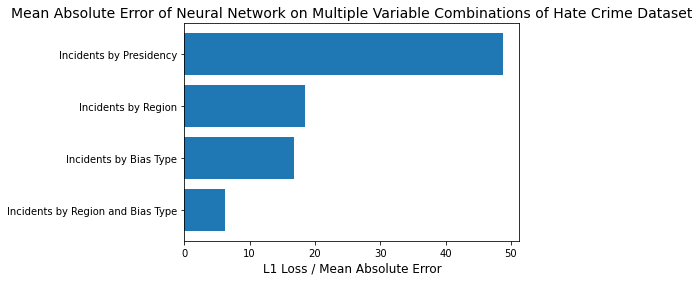

In [56]:
plt.barh(combined_net_results['Title'],combined_net_results['Loss'])
plt.xlabel('L1 Loss / Mean Absolute Error', fontsize=12)
plt.title('Mean Absolute Error of Neural Network on Multiple Variable Combinations of Hate Crime Dataset',
         fontsize=14)

plt.show()

#### Cross Validating Optimizer and Learning Rate

In [57]:
dataset = region_bias_ts
y_column = 'TOTAL_INCIDENTS'
n_nodes=300

In [58]:
X_train, y_train = neural_network_processing(dataset, y_column)

X = dataset.drop([y_column], axis=1)

In [59]:
class ANN_Model(nn.Module):

    def __init__(self, input_features=len(X.columns), 
                 hidden1=n_nodes, 
                 hidden2=n_nodes,
                 hidden3=n_nodes,
                 out_features=1):
        super().__init__()
        self.layer1con = nn.Linear(input_features, hidden1)
        self.layer2con = nn.Linear(hidden1, hidden2)
        self.layer3con = nn.Linear(hidden2, hidden3)
        self.out = nn.Linear(hidden3, out_features)

    def forward(self, x):
        x = F.relu(self.layer1con(x))
        x = F.relu(self.layer2con(x))
        x = F.relu(self.layer3con(x))
        x = self.out(x)
        return(x)

In [64]:
#create instance of model
ann = ANN_Model()

#loss function
loss_function = torch.nn.L1Loss()

# list of optimizers to evaluate
#optimizer_list = [torch.optim.Adam, torch.optim.AdamW]
optimizer_list = [torch.optim.Adadelta, torch.optim.Adagrad, torch.optim.Adam, torch.optim.AdamW,
                   torch.optim.Adamax, torch.optim.ASGD, torch.optim.NAdam, torch.optim.RAdam, 
                   torch.optim.RMSprop,torch.optim.Rprop, torch.optim.SGD]

# for loop to explore different optimizers
for x in optimizer_list:
    
    #optimizer
    optimizer = x(ann.parameters(), lr=0.1)
    
    #run model through multiple epochs/iterations
    final_loss = []
    n_epochs = 201
    
    print(x)
    
    for epoch in range(n_epochs):
        y_pred = ann.forward(X_train)
        loss = loss_function(y_pred, y_train)
        final_loss.append(loss)

        if epoch == 200:
            print(f'Optimizer {x}: Epoch number {epoch} with loss, {loss}')

        # impliment optimizer
        # gradient descent - zero the gradient before running backwards propagation
        optimizer.zero_grad()
        loss.backward()
        #perform optimization step for each epoch
        optimizer.step()


<class 'torch.optim.adadelta.Adadelta'>
Optimizer <class 'torch.optim.adadelta.Adadelta'>: Epoch number 200 with loss, 8.26803207397461
<class 'torch.optim.adagrad.Adagrad'>
Optimizer <class 'torch.optim.adagrad.Adagrad'>: Epoch number 200 with loss, 8.161968231201172
<class 'torch.optim.adam.Adam'>
Optimizer <class 'torch.optim.adam.Adam'>: Epoch number 200 with loss, 8.15465259552002
<class 'torch.optim.adamw.AdamW'>
Optimizer <class 'torch.optim.adamw.AdamW'>: Epoch number 200 with loss, 8.378963470458984
<class 'torch.optim.adamax.Adamax'>
Optimizer <class 'torch.optim.adamax.Adamax'>: Epoch number 200 with loss, 8.376167297363281
<class 'torch.optim.asgd.ASGD'>
Optimizer <class 'torch.optim.asgd.ASGD'>: Epoch number 200 with loss, 8.376479148864746
<class 'torch.optim.nadam.NAdam'>
Optimizer <class 'torch.optim.nadam.NAdam'>: Epoch number 200 with loss, 8.377199172973633
<class 'torch.optim.radam.RAdam'>
Optimizer <class 'torch.optim.radam.RAdam'>: Epoch number 200 with loss, 8.37